# DETECÇÃO DE PONTOS DE MUDANÇA

In [1]:
import numpy as np
import pandas as pd
import random
import datetime
import math
import decimal
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-darkgrid')

from numpy.random import seed
from numpy.random import randn
from scipy import stats
from scipy.special import logsumexp

np.seterr(divide='raise') #Forço erros de divisão

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
def Serie_Teste(u1=1, u2=2):    
    yt1 = u1 + 0.1*randn(30)
    yt2 = u2 + 0.1*randn(30)
    
    y = np.concatenate((yt1, yt2), axis=0)
    plt.figure(figsize=(16, 10))
    plt.plot(y)
    
    return y

In [4]:
def Centro_Kohonen(y, X=0, K=2, alfa=0.8, C=50):    
# Este programa encontra dois centros em uma série temporal com o intuito de fuzzyficar a mesma para ser utilizada no
# amostrador de Gibbs e CUSUM para detectar pequenos pontos de mudança na série.

#Parâmetros:
#Y = Série temporal
#M = número de padrões de entrada
#N = dimensão do padrão de entrada, para o nosso caso será sempre 1
#K = número de neurônios, para o o problema proposto (número de centros)
    M = y.shape[0]
    N = 1
    f = 0

    #Inicialização dos pesos
    I = y.argsort(axis=0) # Indices ordenados
    Y = np.sort(y)        # Pontos na série ordenados
    
    c1 = Y[0:7]           # Começo da série      
    c2 = Y[M-7:M]         # Fim da série
    
    
    #Ajustes dos valores
    while np.std(c2) > 0.1: #Enquanto o desvio padrão for superior a 0.1, substituo o maior valor pela média 
        ma = c2.argmax()
        c2[ma] = np.mean(c2);    
        y[I[ma+60-7]] = np.mean(c2);    

    while np.std(c1) > 0.1: #Enquanto o desvio padrão for superior a 0.1, substituo o menor valor pela média 
        mi = c1.argmin()
        c1[mi] = np.mean(c1)
        y[I[mi]] = np.mean(c1);
    
    #Definição dos valores dos pesos
    W = [np.mean(c1), np.mean(c2)] 
    
    #Encontrando centros a partir do treinamento da rede de Kohonen    
    for l in range(1, C+1):
        alfa=alfa*(1-(C-(C-l))/C)
        
        for i in range(0, M): #Para cada valor na série
            a=999
            
            for j in range(0, K): #Para o número de clusters definido na série
                if np.linalg.norm([(y[i]-W[j])], 2) < a:
                    a = np.linalg.norm([(y[i]-W[j])], 2)
                    f = j
                
            W[f] = W[f]+alfa*(y[i]-W[f])
    
    
    return c1, c2, I, Y, W, a, alfa

In [5]:
def Pertinencia_Fuzzy(y, W):
    # Autor: M. F. S. V. D'Angelo
    # Data: 04/07/06
    # Este programa encontra valores de pertinência para uma série tempoal a partir de centros previamente especificados.
    # Sendo: y: série temporal; c: vetor contendo centros; 
    centro_1 = []
    centro_2 = []
    n = y.shape[0]
    l = 2

    # Encontrando as pertinencias de cada ponto da série para cada cluster
    for i in range(0, l):
        for t in range(0, n):
            soma=0;
            for k in range(0, l):
                soma = soma+(y[t]-W[k])*(y[t]-W[k])

            #m[i,t] = 1-((y[t]-W[i])*(y[t]-W[i]))/soma
            if i == 0:
                centro_1.append(np.round(1-((y[t]-W[i])*(y[t]-W[i]))/soma, 3))
            else:
                centro_2.append(np.round(1-((y[t]-W[i])*(y[t]-W[i]))/soma, 3))

    return centro_1, centro_2

In [6]:
def Metropolis_Hastings(y, sim=1000, shape=10, scale=0.1, loc=0):
    n = len(y)
    m = 1 + round((n-1) * np.random.uniform(0, 1))

    #Lista de retorno com parâmetros
    a_params = []
    b_params = []
    c_params = []
    d_params = [] 
    m_params = []


    #Distribuições Gamma
    a = stats.erlang.rvs(shape, loc=loc, scale=scale, size=1, random_state=None)[0] #np.random.gamma(shape, scale, 1)[0]
    b = stats.erlang.rvs(shape, loc=loc, scale=scale, size=1, random_state=None)[0] #np.random.gamma(shape, scale, 1)[0]
    c = stats.erlang.rvs(shape, loc=loc, scale=scale, size=1, random_state=None)[0] #np.random.gamma(shape, scale, 1)[0]
    d = stats.erlang.rvs(shape, loc=loc, scale=scale, size=1, random_state=None)[0] #np.random.gamma(shape, scale, 1)[0]
    
    
    for i in range(0, sim): 
        m1 = 1+round((n-1) * np.random.uniform(0, 1));
        a1 = stats.erlang.rvs(shape, loc=loc, scale=scale, size=1, random_state=None)[0] #np.random.gamma(shape, scale, 1)[0]
        b1 = stats.erlang.rvs(shape, loc=loc, scale=scale, size=1, random_state=None)[0] #np.random.gamma(shape, scale, 1)[0]
        c1 = stats.erlang.rvs(shape, loc=loc, scale=scale, size=1, random_state=None)[0] #np.random.gamma(shape, scale, 1)[0]
        d1 = stats.erlang.rvs(shape, loc=loc, scale=scale, size=1, random_state=None)[0] #np.random.gamma(shape, scale, 1)[0]

        #PARÂMETRO A    
        aux1 = 1
        for j in range(0, m):
            try:
                aux1 = aux1 * (y[j] ** (a1-1))
            except:
                aux1 = aux1


        aux2 = 1
        for j in range(0, m):
            try:
                aux2 = aux2 * y[j] ** (a-1)
            except:
                aux2 = aux2            

        try:
            ra = ((math.gamma(a1+b)/math.gamma(a1))**m)*aux1*((((a/a1)**.9)*math.exp(-.1*(a1-a)))**2)/(((math.gamma(a+b)/math.gamma(a))**m)*aux2)  
            if (min(1, ra) > np.random.uniform(0, 1)):
                a=a1
        except:
            pass

        #PARÂMETRO B
        aux1 = 1
        for j in range(0, m):
            try:
                aux1 = aux1*(1-y[j])**(b1-1)
            except:
                aux1 = aux1


        aux2 = 1
        for j in range(0, m):
            try:
                aux2 = aux2*(1-y[j])**(b-1)
            except:
                aux2 = aux2
                
        try:
            rb = ((math.gamma(a+b1)/math.gamma(b1))**m)*aux1*((((b/b1)**.9)*math.exp(-.1*(b1-b)))**2)/(((math.gamma(a+b)/math.gamma(b))**m)*aux2)
            if (min(1, rb) > np.random.uniform(0, 1)):
                b = b1
        except:
            pass


        #PARÂMETRO C
        aux1 = 1
        for j in range(m, n):
            try:
                aux1=aux1*y[j]**(c1-1)
            except:
                aux1 = aux1

        aux2 = 1
        for j in range(m, n):
            try:
                aux2=aux2*y[j]**(c-1)
            except:
                aux2 = aux2

        try:
            rc = ((math.gamma(c1+d)/math.gamma(c1))**(n-m))*aux1*((((c/c1)**.9)*math.exp(-.1*(c1-c)))**2)/(((math.gamma(c+d)/math.gamma(c))**(n-m))*aux2)
            if (min(1, rc) > np.random.uniform(0, 1)):
                c = c1
        except:
            pass


        #PARÂMETRO D    
        aux1 = 1
        for j in range(m, n):
            try:
                aux1=aux1*(1-y[j])**(d1-1)
            except:
                aux1 = aux1

        aux2 = 1
        for j in range(m, n):
            try:
                aux2=aux2*(1-y[j])**(d-1)
            except:
                aux2 = aux2            

        try:
            rd = ((math.gamma(c+d1)/math.gamma(d1))**(n-m))*aux1*((((d/d1)**.9)*math.exp(-.1*(d1-d)))**2)/(((math.gamma(c+d)/math.gamma(d))**(n-m))*aux2)
            if (min(1, rd) > np.random.uniform(0, 1)):
                d = d1
        except:
            pass
  

        #PARÂMETRO M
        aux1 = 1 
        for j in range(0, m1):
            try:
                aux1 = aux1*(y[j]**(a-1))*((1-y[j])**(b-1))
            except:
                aux1 = aux1

        aux2 = 1;
        for j in range(m1, n):
            try:
                aux2 = aux2*(y[j]**(c-1))*((1-y[j])**(d-1))            
            except:
                aux2 = aux2

        aux3 = 1
        for j in range(0, m):
            try:
                aux3 = aux3*(y[j]**(a-1))*((1-y[j])**(b-1))            
            except:
                aux3 = aux3

        aux4 = 1
        for j in range(m, n):
            try:
                aux4 = aux4*(y[j]**(c-1))*((1-y[j])**(d-1))
            except:
                aux4 = aux4

        try:
            rm = (((math.gamma(a+b)/(math.gamma(a)*math.gamma(b)))**m1)*((math.gamma(c+d)/(math.gamma(c)*math.gamma(d)))**(n-m1))*aux1*aux2)/(((math.gamma(a+b)/(math.gamma(a)*math.gamma(b)))**m)*((math.gamma(c+d)/(math.gamma(c)*math.gamma(d)))**(n-m))*aux3*aux4)        
            if (min(1, rm) > np.random.uniform(0, 1)):
                m = m1
        except:
            pass


        #if i >= 500: #Descarto os primeiros 500
        #Adiciono os valores nas listas com os parâmetros
        a_params.append(a)
        b_params.append(b)
        c_params.append(c)
        d_params.append(d)
        m_params.append(m)

            
    return a_params, b_params, c_params, d_params, m_params

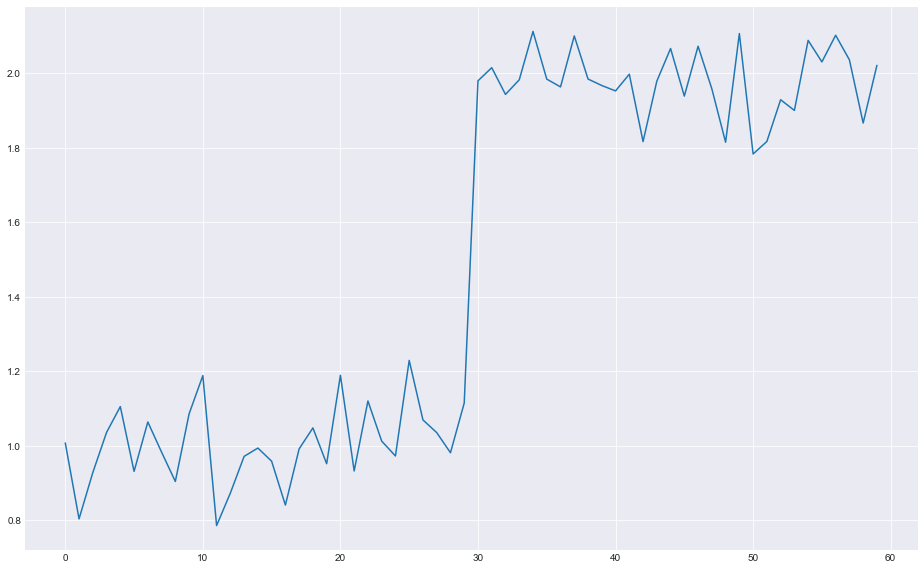

In [7]:
y = Serie_Teste(u1=1, u2=2)

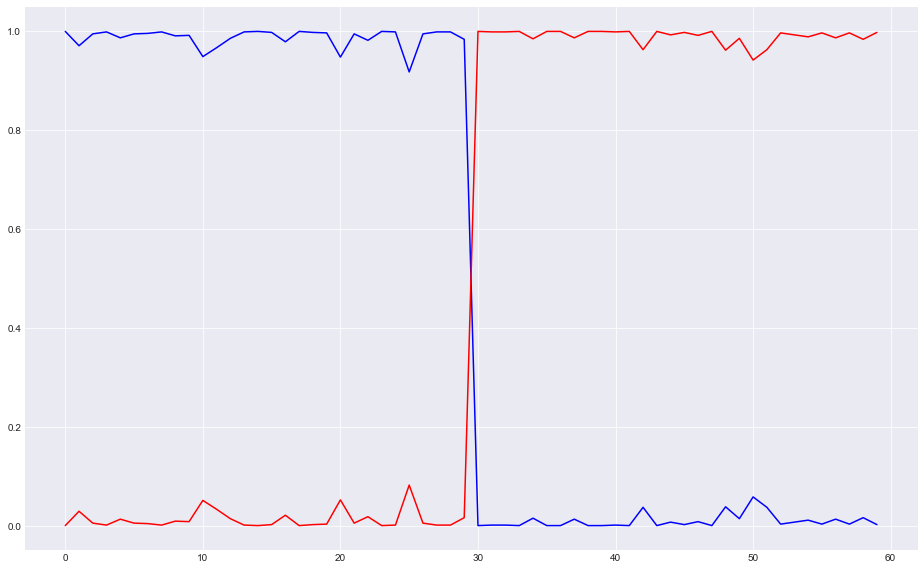

In [8]:
c1, c2, I, Y, W, a, alfa = Centro_Kohonen(y, X=0, K=2, alfa=0.8, C=500)
centro_1, centro_2 = Pertinencia_Fuzzy(y, W)

plt.figure(figsize=(16, 10))
plt.plot(centro_1, 'b') # plotting t, a separately 
plt.plot(centro_2, 'r') # plotting t, b separately 
plt.show()

[Text(0.5, 0, 'Simulações'), Text(0, 0.5, 'Pontos de Mudança Candidatos (m)')]

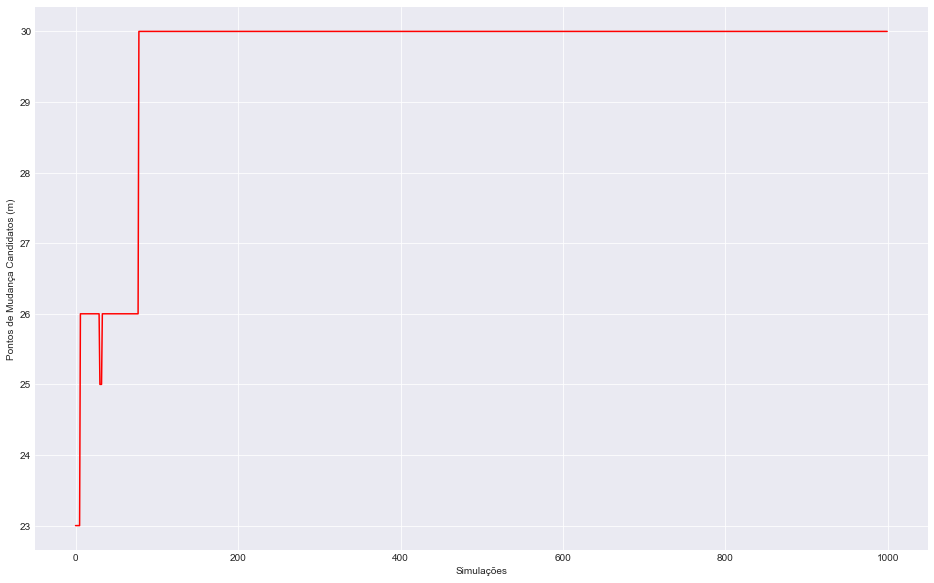

In [11]:
a_params, b_params, c_params, d_params, m_params = Metropolis_Hastings(centro_1, sim=1000)

fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.plot(m_params, 'r')
ax.set(xlabel='Simulações', ylabel='Pontos de Mudança Candidatos (m)')

<AxesSubplot:xlabel='Pontos de Mudança Candidatos', ylabel='Densidade'>

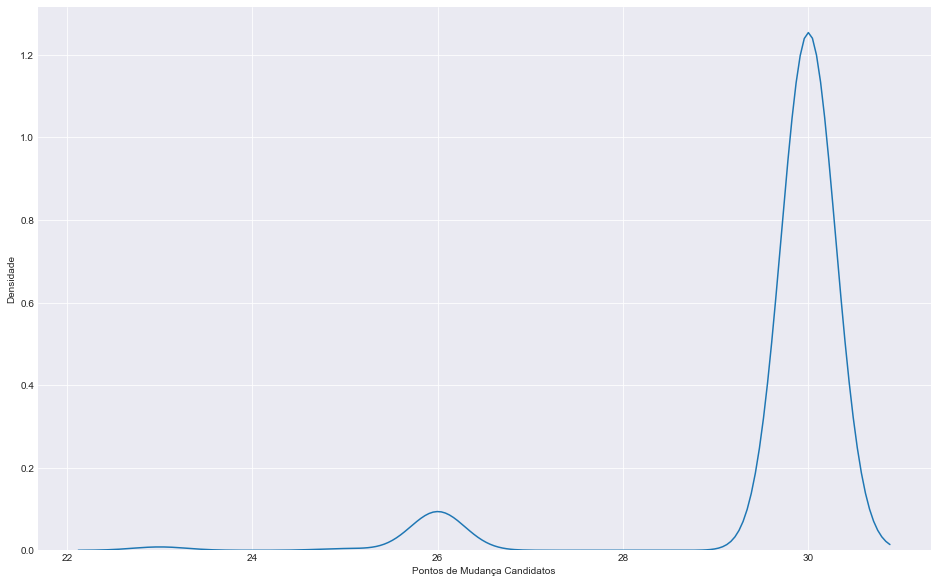

In [16]:
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set(xlabel='Pontos de Mudança Candidatos', ylabel='Densidade')
sns.kdeplot(m_params, common_norm=True, common_grid=True)

<AxesSubplot:ylabel='Densidade'>

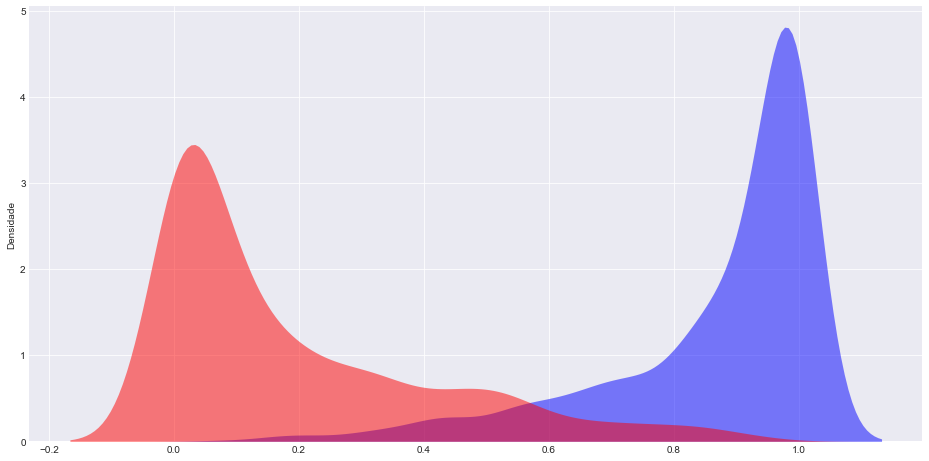

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_ylabel('Densidade')

beta_1 = np.random.beta(np.mean(a_params[200:]), np.mean(b_params[200:]), size=1000)
beta_2 = np.random.beta(np.mean(c_params[200:]), np.mean(d_params[200:]), size=1000)

sns.kdeplot(beta_1, color='b', fill=True, common_norm=False, alpha=.5, linewidth=0)
sns.kdeplot(beta_2, color='r', fill=True, common_norm=False, alpha=.5, linewidth=0)

<AxesSubplot:ylabel='Densidade do Parâmetro d'>

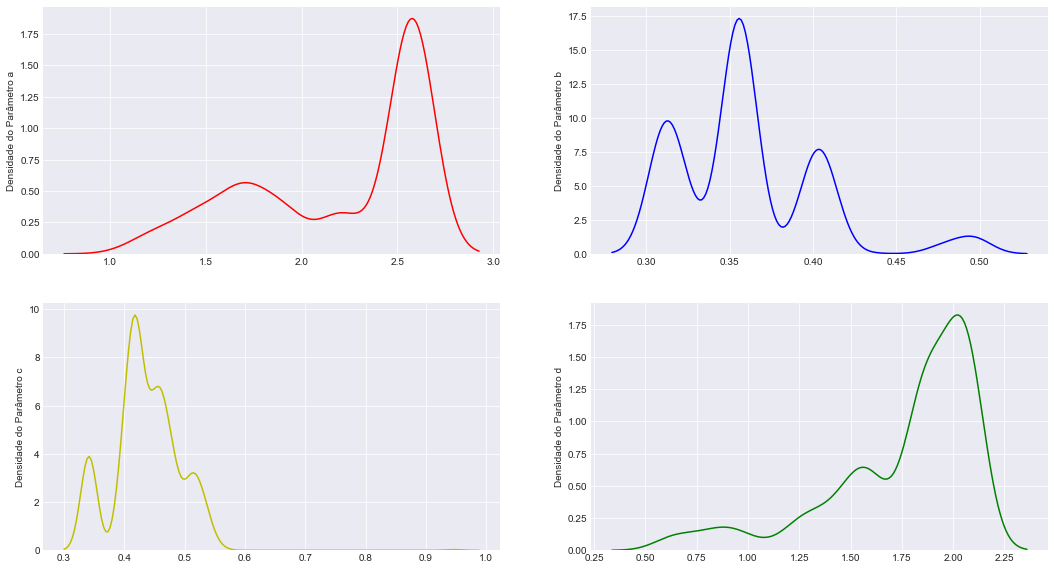

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].set_ylabel('Densidade do Parâmetro a')
axes[0,1].set_ylabel('Densidade do Parâmetro b')
axes[1,0].set_ylabel('Densidade do Parâmetro c')
axes[1,1].set_ylabel('Densidade do Parâmetro d')

sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.kdeplot(a_params, ax=axes[0, 0], color='r')
sns.kdeplot(b_params, ax=axes[0, 1], color='b')
sns.kdeplot(c_params, ax=axes[1, 0], color='y')
sns.kdeplot(d_params, ax=axes[1, 1], color='g')